# Load checkpoint

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

from _config import PATH_CHECKPOINT, PATH_TO_CONFIG
from data_loader import MyDataLoader, SPLIT
from models import *
from my_config import MyConfig, load_config
from train import model, DEVICE, TimeSeriesDataset, BATCH_SIZE

# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(PATH_CHECKPOINT) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[1]
    print(f"Loading latest checkpoint: {latest_checkpoint_file}")

    model.load_state_dict(torch.load(PATH_CHECKPOINT / latest_checkpoint_file, map_location=DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {PATH_CHECKPOINT}")

Loading latest checkpoint: checkpoint_20.pt


# Load test data

In [2]:
# --- Reconstruct continuous one-step-ahead forecasts for 2024

# 1) Reload the full DataFrame (so we get the original timestamps)
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)

X, y, ts = data_loader.get_X_y(SPLIT.TEST, input_seq_len=60, rolling=True, verbose=True)
test_dataset = TimeSeriesDataset(X, y, device=DEVICE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Before creating sequences: X shape: (469971, 11), y shape: (469971, 1)
After creating sequences: X shape: (426895, 60, 11), y shape: (426895, 60, 1)


# Make predictions

In [3]:
import numpy as np

model.eval()
preds = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        predictions = model(batch_X)
        preds.append(predictions.cpu().numpy())

y_test = y.squeeze()
preds = np.concatenate(preds).squeeze()
display(ts.shape, y_test.shape, preds.shape)

(426895, 60)

(426895, 60)

(426895, 60)

In [4]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
preds = pd.DataFrame(preds, index=ts[:, 0])
ts = pd.DataFrame(ts, index=ts[:, 0])
y_test.sort_index(inplace=True)
preds.sort_index(inplace=True)
display(y_test.head(), preds.head(), ts.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 08:43:00,0.004765,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:44:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:45:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.004372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:46:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004372,0.009728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:47:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.004372,0.009728,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 08:43:00,0.256763,0.624556,0.509581,0.451600,0.424623,0.409931,0.399695,0.390745,0.383151,0.377555,...,0.317967,0.312472,0.305827,0.299780,0.294201,0.289184,0.285749,0.282040,0.278435,0.275215
2023-01-01 08:44:00,0.261106,0.635550,0.522696,0.463201,0.434897,0.418646,0.405943,0.394933,0.385845,0.375141,...,0.312450,0.305821,0.299776,0.294174,0.289152,0.285738,0.282056,0.278434,0.275203,0.271385
2023-01-01 08:45:00,0.255758,0.628961,0.515495,0.458285,0.431267,0.415445,0.402910,0.391704,0.378550,0.363180,...,0.305634,0.299597,0.293993,0.288988,0.285563,0.281879,0.278270,0.275039,0.271246,0.266440
2023-01-01 08:46:00,0.263181,0.632980,0.524369,0.465430,0.436512,0.419156,0.404540,0.388158,0.369580,0.353167,...,0.299533,0.293928,0.288919,0.285485,0.281796,0.278217,0.275001,0.271169,0.266384,0.261442
2023-01-01 08:47:00,0.222007,0.647226,0.538324,0.475268,0.443634,0.423223,0.402823,0.380651,0.360847,0.345541,...,0.293899,0.288888,0.285469,0.281779,0.278184,0.274966,0.271138,0.266341,0.261432,0.256944


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 08:43:00,2023-01-01 08:43:00,2023-01-01 08:44:00,2023-01-01 08:45:00,2023-01-01 08:46:00,2023-01-01 08:47:00,2023-01-01 08:48:00,2023-01-01 08:49:00,2023-01-01 08:50:00,2023-01-01 08:51:00,2023-01-01 08:52:00,...,2023-01-01 09:33:00,2023-01-01 09:34:00,2023-01-01 09:35:00,2023-01-01 09:36:00,2023-01-01 09:37:00,2023-01-01 09:38:00,2023-01-01 09:39:00,2023-01-01 09:40:00,2023-01-01 09:41:00,2023-01-01 09:42:00
2023-01-01 08:44:00,2023-01-01 08:44:00,2023-01-01 08:45:00,2023-01-01 08:46:00,2023-01-01 08:47:00,2023-01-01 08:48:00,2023-01-01 08:49:00,2023-01-01 08:50:00,2023-01-01 08:51:00,2023-01-01 08:52:00,2023-01-01 08:53:00,...,2023-01-01 09:34:00,2023-01-01 09:35:00,2023-01-01 09:36:00,2023-01-01 09:37:00,2023-01-01 09:38:00,2023-01-01 09:39:00,2023-01-01 09:40:00,2023-01-01 09:41:00,2023-01-01 09:42:00,2023-01-01 09:43:00
2023-01-01 08:45:00,2023-01-01 08:45:00,2023-01-01 08:46:00,2023-01-01 08:47:00,2023-01-01 08:48:00,2023-01-01 08:49:00,2023-01-01 08:50:00,2023-01-01 08:51:00,2023-01-01 08:52:00,2023-01-01 08:53:00,2023-01-01 08:54:00,...,2023-01-01 09:35:00,2023-01-01 09:36:00,2023-01-01 09:37:00,2023-01-01 09:38:00,2023-01-01 09:39:00,2023-01-01 09:40:00,2023-01-01 09:41:00,2023-01-01 09:42:00,2023-01-01 09:43:00,2023-01-01 09:44:00
2023-01-01 08:46:00,2023-01-01 08:46:00,2023-01-01 08:47:00,2023-01-01 08:48:00,2023-01-01 08:49:00,2023-01-01 08:50:00,2023-01-01 08:51:00,2023-01-01 08:52:00,2023-01-01 08:53:00,2023-01-01 08:54:00,2023-01-01 08:55:00,...,2023-01-01 09:36:00,2023-01-01 09:37:00,2023-01-01 09:38:00,2023-01-01 09:39:00,2023-01-01 09:40:00,2023-01-01 09:41:00,2023-01-01 09:42:00,2023-01-01 09:43:00,2023-01-01 09:44:00,2023-01-01 09:45:00
2023-01-01 08:47:00,2023-01-01 08:47:00,2023-01-01 08:48:00,2023-01-01 08:49:00,2023-01-01 08:50:00,2023-01-01 08:51:00,2023-01-01 08:52:00,2023-01-01 08:53:00,2023-01-01 08:54:00,2023-01-01 08:55:00,2023-01-01 08:56:00,...,2023-01-01 09:37:00,2023-01-01 09:38:00,2023-01-01 09:39:00,2023-01-01 09:40:00,2023-01-01 09:41:00,2023-01-01 09:42:00,2023-01-01 09:43:00,2023-01-01 09:44:00,2023-01-01 09:45:00,2023-01-01 09:46:00


# Plot predictions

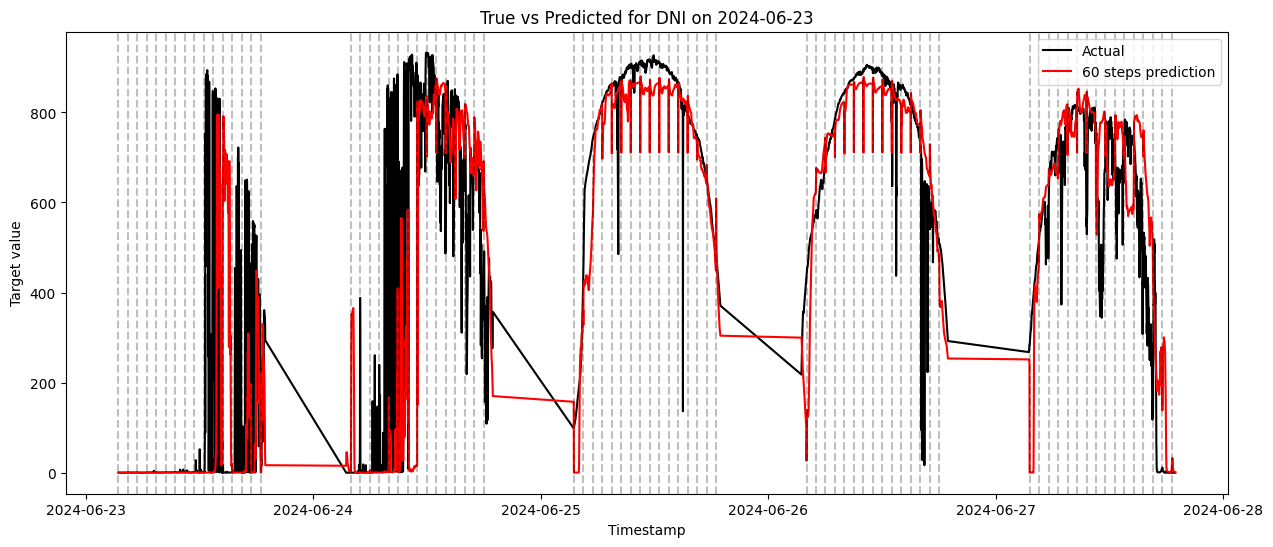

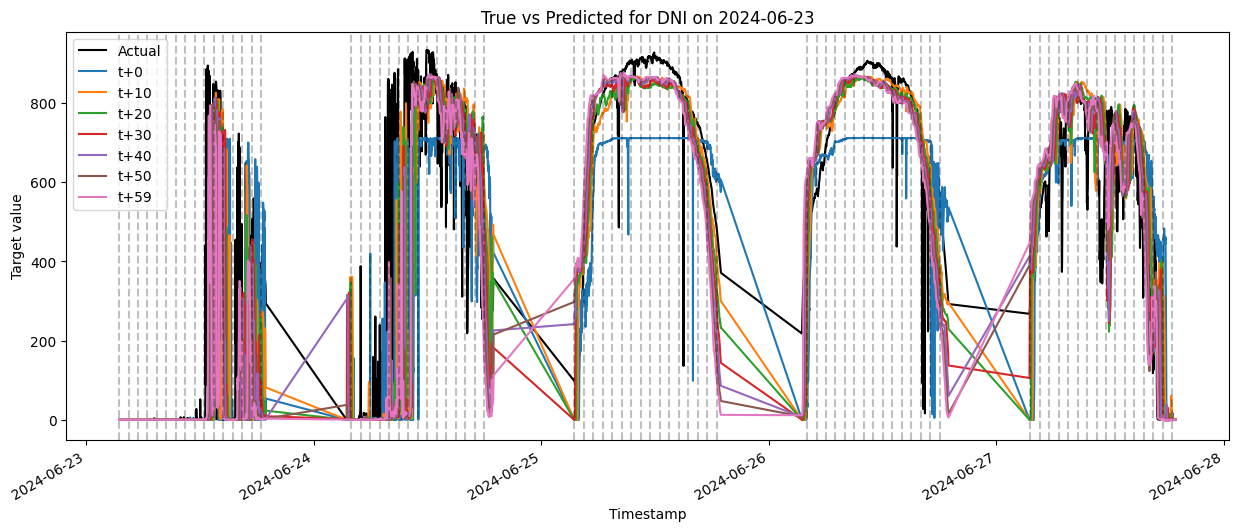

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-06-23'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=5)
# Filter the timestamps for the selected day
day_mask = (ts.index >= day_start) & (ts.index < day_end)
day_ts = ts[day_mask][0].values

# Plot actual values
ax.plot(day_ts, y_test[day_mask][0].values, label='Actual', color='black')
ax.plot(day_ts, preds[day_mask][::60].values.flatten()[:len(day_ts)], label='60 steps prediction', color='red')
# add vertical lines at every 60th timestep
for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

ax.set_title(f"True vs Predicted for {my_config.TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
y_test[day_mask][0].plot(ax=ax, label='Actual', color='black', title=f"True vs Predicted for {my_config.TARGETS[0]} on {day}", xlabel="Timestamp", ylabel="Target value", legend=True)
prediction_steps = list(range(0, 60, 10))
prediction_steps.append(59)
for i in prediction_steps:
    preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}", legend=True)

for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

plt.show()

In [6]:
from ForecastEvaluator import ForecastEvaluator


def calculate_errors(y_true, y_pred):
    return ForecastEvaluator(y_true, y_pred).evaluate_all()


error_metrics = {}
for i in range(60):
    error_metrics[f't+{i}'] = calculate_errors(y_test[0], preds[i])

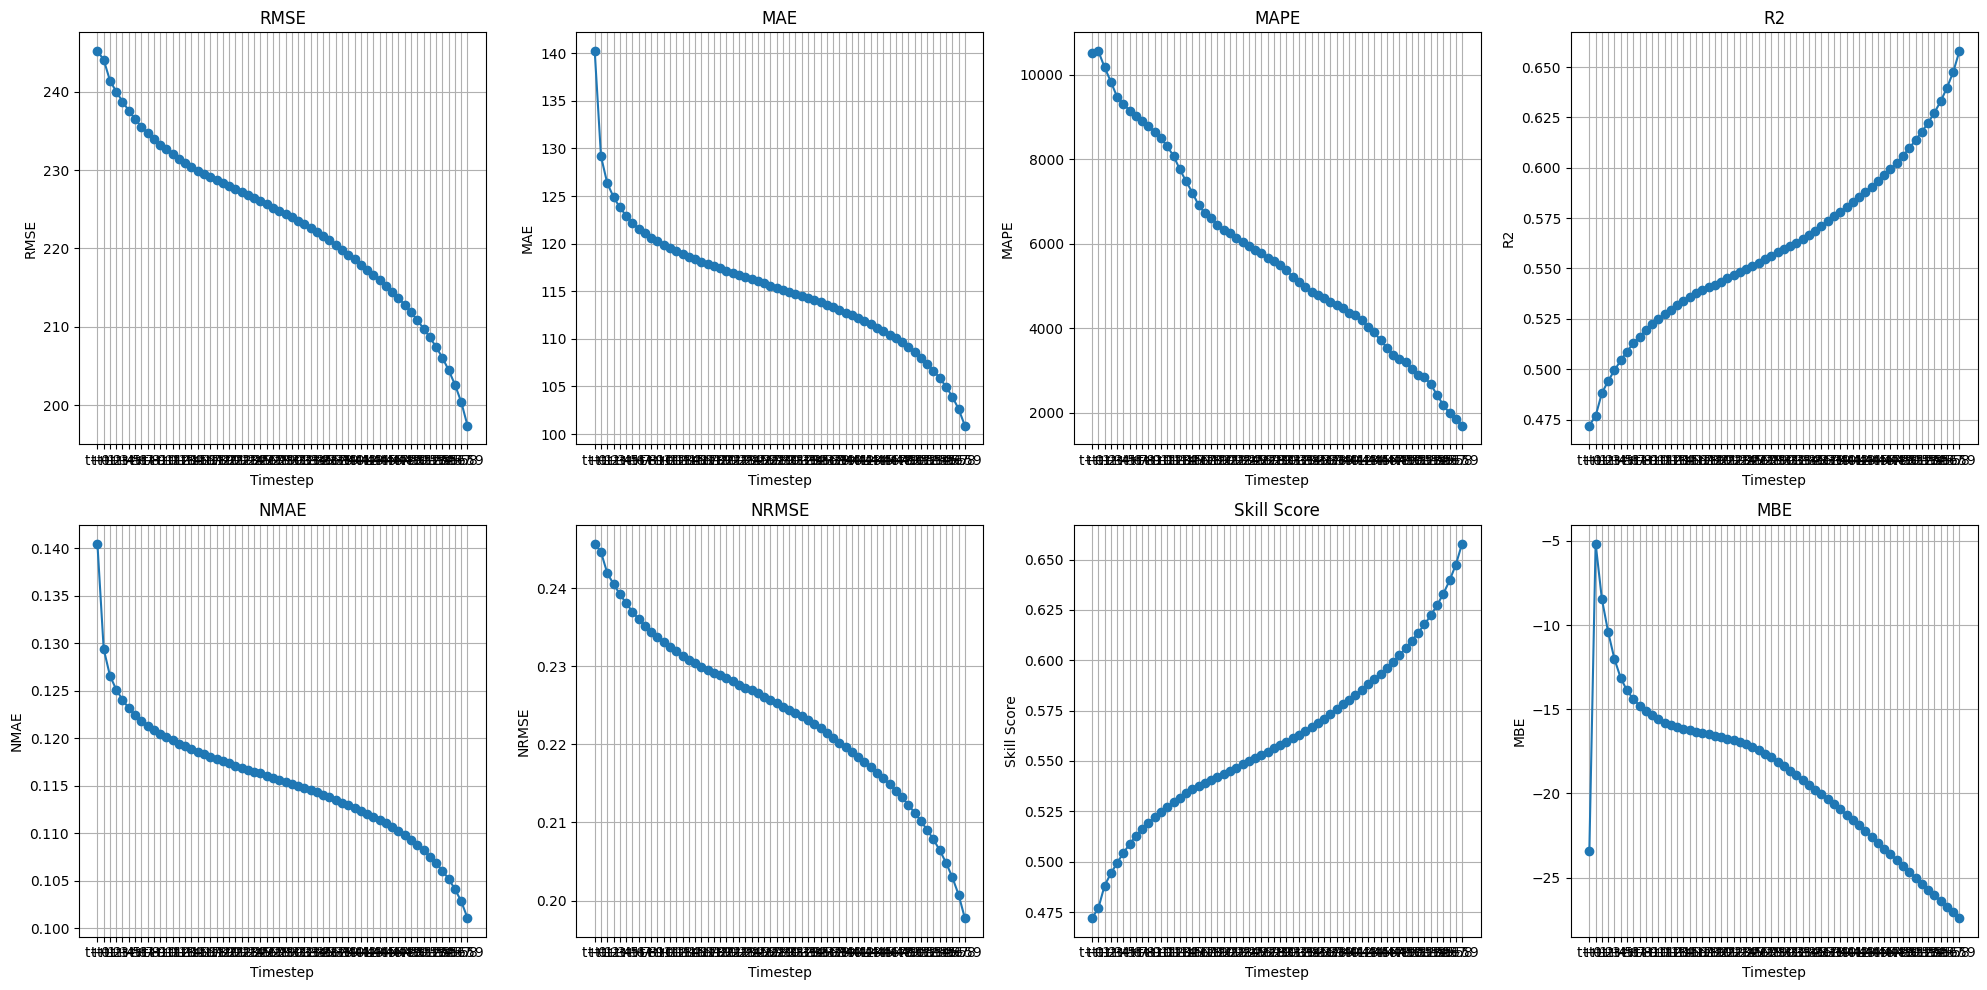

In [7]:
# Extract the timestep keys and error metrics
timesteps = list(error_metrics.keys())
metrics = list(error_metrics['t+56'].keys())

# Prepare figure and axes for subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Plot each metric on a separate subplot
for i, metric in enumerate(metrics):
    values = [error_metrics[ts][metric] for ts in timesteps]
    axs[i].plot(timesteps, values, marker='o')
    axs[i].set_title(metric)
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()